In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
from pyke.prf import SimpleKeplerPRF

/Users/jvmirca/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [20]:
prf = SimpleKeplerPRF(channel=16, shape=(11, 11), column=250, row=200)

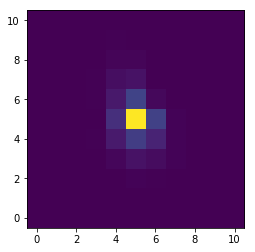

In [21]:
plt.imshow(prf(flux=1e4, center_col=255.5, center_row=205.5), origin='lower')

In [22]:
import numpy as np
from scipy import signal

In [23]:
cadences = np.arange(1000)

In [24]:
A = 1e4 + 1e2 * np.sin(2 * np.pi * np.linspace(0, 6, 1000)) + 300 * np.linspace(0, 1, 1000)
xc = 255.5 + 0.05 * np.random.normal(size=1000) + .3*signal.sawtooth(np.linspace(0, 100, 1000))
yc = 205.5 + 0.05 * np.random.normal(size=1000) + .3 - .3*signal.sawtooth(np.linspace(0, 100, 1000))

In [640]:
tpf = np.array([np.random.poisson(prf(flux=A[i], center_col=xc[i], center_row=yc[i]) + 3) for i in range(1000)])

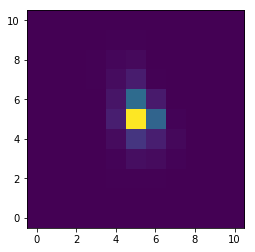

In [34]:
plt.imshow(tpf[100], origin='lower')

In [31]:
lc = np.sum(tpf, axis=(1,2))

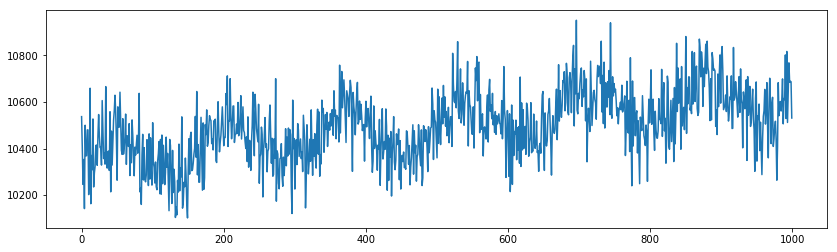

In [32]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, lc)

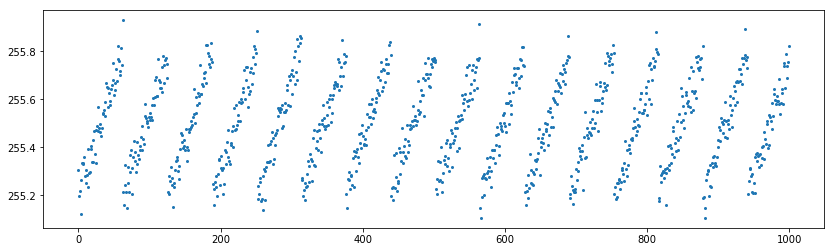

In [33]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, xc, 'o', markersize=2)

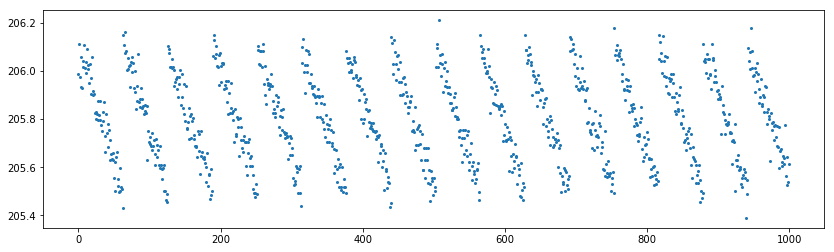

In [34]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, yc, 'o', markersize=2)

In [35]:
from pyke.prf import PRFPhotometry

In [36]:
from oktopus.models import IntegratedSymmetricGaussian2D

In [37]:
from oktopus.prior import UniformPrior

In [38]:
y, x = np.indices(prf.shape) + 0.5

In [39]:
x = x + 250
y = y + 200

In [40]:
psf = IntegratedSymmetricGaussian2D(x, y)

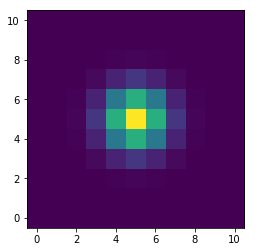

In [41]:
plt.imshow(psf(1000, 255.5, 205.5, 1), origin='lower')

In [42]:
prior = UniformPrior(lb=[5e3, 253.5, 203.5, .25],
                     ub=[15e3, 257.5, 207.5, 1.25])

In [43]:
phot_poisson = PRFPhotometry(scene_model=psf, prior=prior)

In [44]:
results_poisson = phot_poisson.fit(tpf_flux=tpf)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/core.py:82: RuntimeWarning: divide by zero encountered in log
  result_value = self.fun(*argvals, **kwargs)
/Users/jvmirca/dev/oktopus/oktopus/likelihood.py:247: RuntimeWarning: invalid value encountered in multiply
  return np.nansum(self.mean(*params) - self.data * np.log(self.mean(*params)))
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
100%|██████████| 1000/1000 [00:24<00:00, 40.85it/s]


In [45]:
flux = results_poisson[:, 0]
xcenter = results_poisson[:, 1]
ycenter = results_poisson[:, 2]
shape = results_poisson[:, 3]

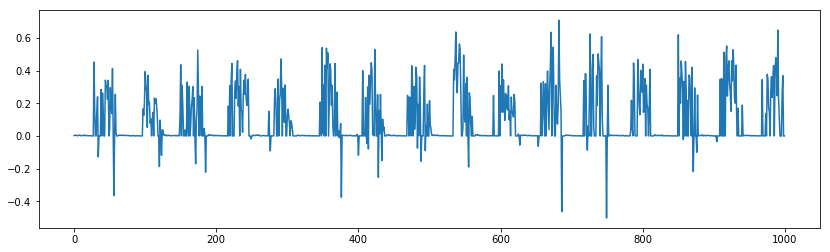

In [46]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, flux - lc)

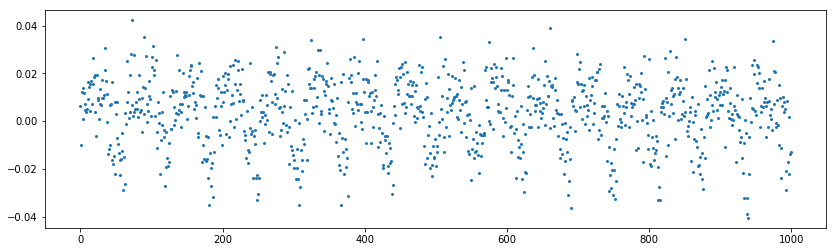

In [47]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, xcenter - xc, 'o', markersize=2)

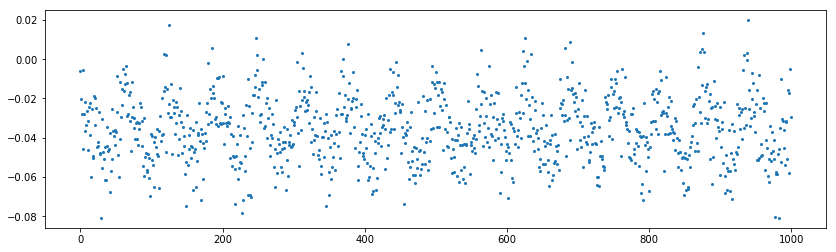

In [48]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, ycenter - yc, 'o', markersize=2)

In [49]:
from oktopus import GaussianPosterior

In [28]:
phot_gauss = PRFPhotometry(scene_model=psf, prior=prior, loss_function=GaussianPosterior, var=1.)

In [29]:
results_gauss = phot_gauss.fit(tpf_flux=tpf)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
100%|██████████| 1000/1000 [00:43<00:00, 21.05it/s]


In [30]:
flux = results_gauss[:, 0]
xcenter = results_gauss[:, 1]
ycenter = results_gauss[:, 2]
shape = results_gauss[:, 3]

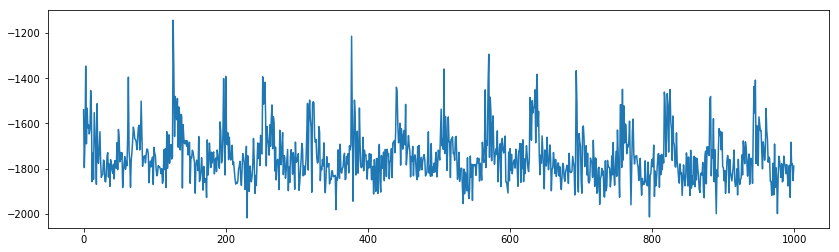

In [31]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, flux - lc)

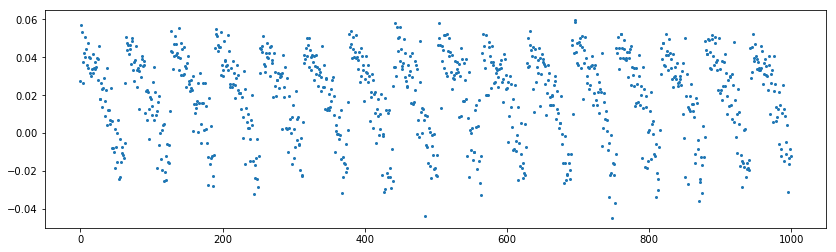

In [32]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, xcenter - xc, 'o', markersize=2)

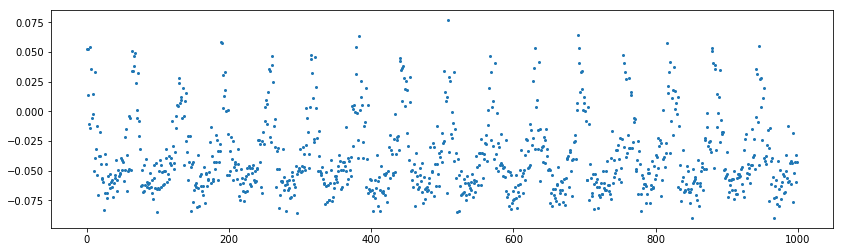

In [33]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, ycenter - yc, 'o', markersize=2)

In [1]:
def dectector():
    """
    Returns
    -------
    det : ndarray
        Returns the log of the pixel flat-field.
        Each position (x, y) corresponds to a parameter
        that will be improved (fitted).
    """
    
    return np.zeros((44, 44))

IndentationError: expected an indented block (<ipython-input-1-3b5785ea00d0>, line 15)

In [ ]:
def improve_detector():

In [ ]:
def star_model(pix_series):
    xc, yc = compute_centroid(pix_series) # [xc]: n_cadences
    # interpolate ("put the data in a finer grid") for each cadence
    # return the evaluation (median or mean) for all cadences

In [ ]:
def improve_star_model():

In [ ]:
def lnlikelihood():
    """
    Returns
    -------
        lnlike, grad_lnlike
    """

In [641]:
import numpy as np

In [642]:
x = np.linspace(0, 10, 11)

In [643]:
y = np.linspace(0, 10, 11)

In [644]:
xp = np.linspace(0, 10, 44)
yp = np.linspace(0, 10, 44)

In [645]:
from scipy.interpolate import RectBivariateSpline

In [646]:
tpf += 1

In [647]:
tpf = np.log(tpf)

In [648]:
interp = [RectBivariateSpline(x, y, tpf[i], kx=1, ky=1) for i in range(tpf.shape[0])]

In [649]:
super_tpf = np.array([interp[i](yp + (yc[i] - 205.5), xp + (xc[i] - 255.5)) for i in range(len(xc))])

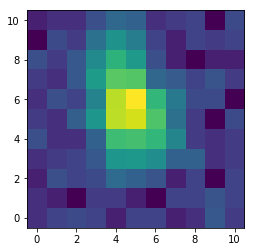

In [650]:
plt.imshow(tpf[1], origin='lower')

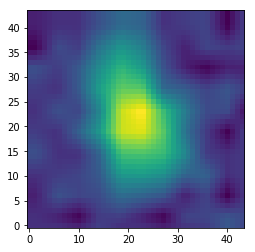

In [651]:
plt.imshow(super_tpf[1], origin='lower')

In [652]:
mean_super_tpf = np.mean(super_tpf, axis=0)

In [653]:
mean_super_tpf.shape

(44, 44)

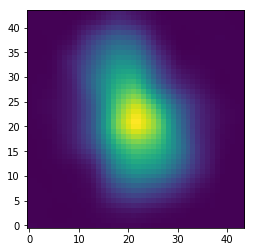

In [654]:
plt.imshow(mean_super_tpf, origin='lower')

In [655]:
norm_super_tpf = mean_super_tpf / np.sum(mean_super_tpf)

In [656]:
np.sum(norm_super_tpf)

1.0

In [728]:
def model_prime(f, dy, dx, template):
    interp_again = RectBivariateSpline(xp, yp, template, kx=1, ky=1)
    return f * interp_again(yp - dy, xp - dx) + detector

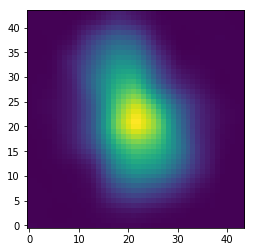

In [658]:
plt.imshow(model_prime(10, 0, 0, norm_super_tpf), origin='lower')

In [659]:
np.sum(model_prime(10, 0, 0, norm_super_tpf))

10.0

In [729]:
def model(f, dy, dx, template):
    tmp = model_prime(f, dy, dx, template).reshape(11, 4, 11, 4)
    return np.sum(tmp, axis=(1, 3))

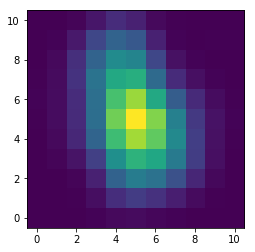

In [661]:
plt.imshow(model(10, 0, 0, norm_super_tpf), origin='lower')

In [662]:
np.sum(model(10, 0, 0, norm_super_tpf))

10.000000000000002

In [663]:
detector = np.zeros((44, 44))

In [664]:
data = tpf[0]

In [730]:
class lnlikelihood:
    def __init__(self, data):
        self.data = data
        
    def evaluate(self, p, template):
        f, dy, dx = p
        r = model(f, dy, dx, template) - self.data
        return np.sum(r * r)

In [666]:
from scipy.optimize import minimize

In [667]:
logL = lnlikelihood(data=tpf[0])

In [668]:
result = minimize(logL.evaluate, x0=(np.log(1e4), 0, 0), args=(norm_super_tpf), method='Powell')

In [670]:
result

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.398038100523188
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.70604321e+02,   4.16538844e-01,  -1.82696234e-01])

In [693]:
f_n, yc_n, xc_n = result.x

In [694]:
xc[0] - 255.5

-0.19510294071179146

In [695]:
yc[0] - 205.5

0.4894297784984758

In [696]:
model_ = model(2.70604321e+02,   4.16538844e-01,  -1.82696234e-01, norm_super_tpf)

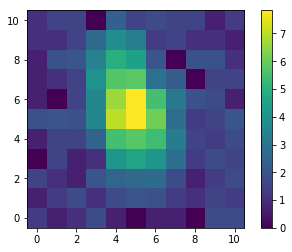

In [697]:
plt.imshow(tpf[0], origin='lower')
plt.colorbar()

In [698]:
np.sum(tpf[0])

260.14716477325101

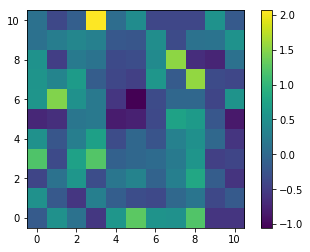

In [699]:
plt.imshow(model_ - tpf[0], origin='lower')
plt.colorbar()

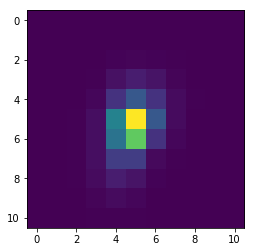

In [700]:
plt.imshow(np.exp(model_))

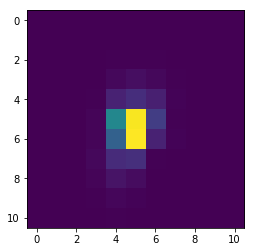

In [701]:
plt.imshow(np.exp(tpf[0]))

In [702]:
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [703]:
interp_ = RectBivariateSpline(x, y, model_ - tpf[0], kx=1, ky=1)

In [704]:
dlnlike_dd = 2 * interp_(yp, xp)

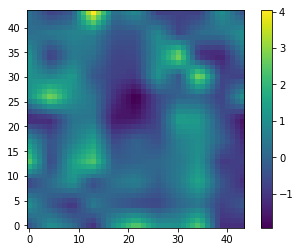

In [705]:
plt.imshow(dlnlike_dd, origin='lower')
plt.colorbar()

In [706]:
dlnlike_dd.shape

(44, 44)

In [707]:
f_n

270.60432058945742

In [708]:
dlnlike_ds = f_n * 2 * interp_(yp - yc_n, xp - xc_n)

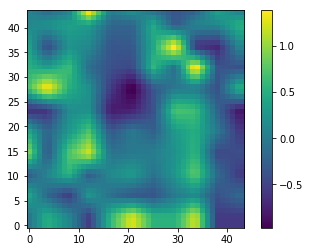

In [709]:
plt.imshow(interp_(yp - yc_n, xp - xc_n), origin='lower')
plt.colorbar()

In [710]:
dlnlike_ds.shape

(44, 44)

In [711]:
tmp_s = np.copy(norm_super_tpf)

In [712]:
logL = lnlikelihood(data=tpf[0])

In [713]:
f_n, yc_n, xc_n

(270.60432058945742, 0.41653884436445743, -0.18269623418449135)

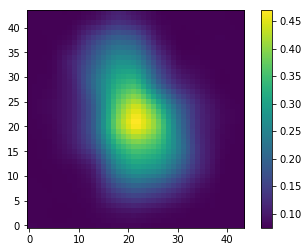

In [714]:
plt.imshow(f_n * tmp_s, origin='lower')
plt.colorbar()

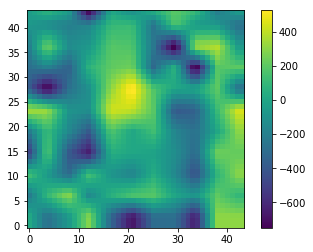

In [715]:
plt.imshow(-dlnlike_ds, origin='lower')
plt.colorbar()

In [740]:
def gradient_descent(arg_template, p):
    f_n, yc_n, xc_n = p
    i = 0
    c = 1e-9
    tmp_s = arg_template
    interp_ = RectBivariateSpline(x, y, model(f_n, yc_n, xc_n, tmp_s) - tpf[0], kx=1, ky=1)
    dlnlike_ds = f_n * 2 * interp_(yp - yc_n, xp - xc_n)
    while i < 2000:
        logL_before = lnlikelihood(data=tpf[0]).evaluate((f_n, yc_n, xc_n), tmp_s)
        tmp_s = tmp_s - c * dlnlike_ds
        logL_after = lnlikelihood(data=tpf[0]).evaluate((f_n, yc_n, xc_n), tmp_s)
        interp_ = RectBivariateSpline(x, y, model(f_n, yc_n, xc_n, tmp_s) - tpf[0], kx=1, ky=1)
        dlnlike_ds = f_n * 2 * interp_(yp - yc_n, xp - xc_n)
        if logL_after < logL_before:
            c *= 1.1
        else:
            c *= .5
        if abs(logL_after - logL_before) < 1e-4:
            break
        print(logL_after)
        print(np.mean(dlnlike_ds), np.std(dlnlike_ds))
        i += 1
    return tmp_s

In [742]:
gd = gradient_descent(tmp_s, result.x)

25.4695097386
20.6905588906 169.189134722
25.412897417
20.6300815879 168.905011961
25.3508523482
20.5637713649 168.593309928
25.2828779683
20.4910891917 168.251442905
25.2084374539
20.4114511533 167.876601874
25.1269515375
20.3242257652 167.465739298
25.0377964486
20.2287313689 167.015553792
24.9403020525
20.1242336828 166.522474909
24.833750275
20.0099435953 165.982648385
24.7173739179
19.8850153126 165.391922242
24.5903559899
19.7485449971 164.745834247
24.4518297026
19.5995700581 164.039601366
24.3008793008
19.4370692911 163.26811195
24.1365419266
19.259964097 162.425921591
23.9578107388
19.0671210507 161.507253717
23.7636395391
18.8573561362 160.506006228
23.5529491757
18.6294410047 159.415765678
23.3246360192
18.3821116662 158.229830743
23.0775828136
18.1140800664 156.941246953
22.8106722091
17.8240490459 155.542854939
22.5228032673
17.5107312106 154.02735464
22.2129111945
17.1728722631 152.387388135
21.8799904931
16.8092793416 150.615643907
21.523121623
16.4188548786 148.70498534

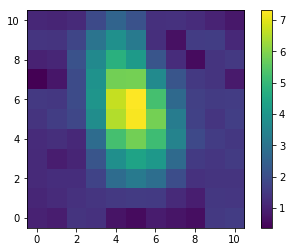

In [718]:
plt.imshow(model(f_n, yc_n, xc_n, tmp_s), origin='lower')
plt.colorbar()

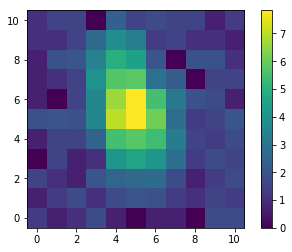

In [719]:
plt.imshow(tpf[0], origin='lower')
plt.colorbar()

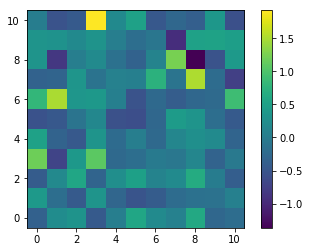

In [720]:
plt.imshow(model(f_n, yc_n, xc_n, tmp_s) - tpf[0], origin='lower')
plt.colorbar()

In [721]:
interp_again = RectBivariateSpline(xp, yp, tmp_s, kx=1, ky=1)

In [743]:
logL = lnlikelihood(data=tpf[0])
result = minimize(logL.evaluate, x0=(np.log(1e4), 0, 0), args=(gd), method='Powell')

In [744]:
result.x

array([  2.70637607e+02,   1.02024374e-01,  -6.77416111e-02])

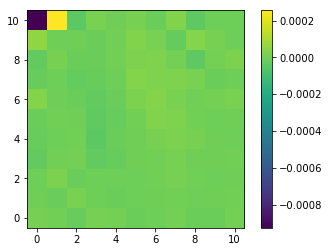

In [746]:
plt.imshow(model(*result.x, gd) - tpf[0], origin='lower')
plt.colorbar()

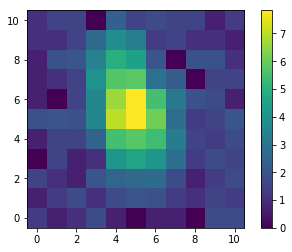

In [748]:
plt.imshow(model(*result.x, gd), origin='lower')
plt.colorbar()